In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns

import sys
sys.path.append('../../../AsymptoticSolver/')
sys.path.append('..')

from Utilities.coord_func import cart2pol
from Utilities.add_var import add_u_polar, get_bg_wind
from AsymptoticSolver import polar_dft, polar_idft, pick_fourier_comp

In [43]:
%matplotlib notebook

### 1. Get data

Initial data is taken from NARVAL simulation for the 17.08.2016 1200 UTC (initialized at 0000 UTC).
Center is calculated with method of centroid pressure.

__Constants:__  
lev_start: Level from where the calculation should start  
km: Radius around the cyclone center  
r_earth: Radius of earth  
r_rad: Radius around the cyclone center in radians

In [2]:
lev_start= 45             
km       = 250                           
r_earth  = 6371                     
r_rad    = km / r_earth

In [3]:
# Data for centerline
center_file       = "../Data/center_fiona.npy" 
center = np.load(center_file)
x_center = center[:,0]
y_center = center[:,1]


# Initial data
ds_orig = xr.open_dataset('../../../../init_data/dei4_NARVALII_2016081700_fg_DOM01_ML_0012.nc')

# Number of levels in file (highest index is lowest level -> p-system)
nlev = len(ds_orig.height.values)
height = ds_orig.z_ifc.values

### 2. Polar coordinate transformation

Select a variable of interest because a memory error occurse when trying to manipulate the whole data set. Create a new polar coord. grid to interpolate the lon-lat data onto.

In [262]:
#var_da = ds_orig.qc[0] + ds_orig.qi[0]
var_da = ds_orig.qv[0]

# Extract region containing cyclone
lonlat_box = {'lon_up':-0.57,'lon_down':-0.68, 'lat_up': 0.17, 'lat_down': 0.30}

 # Select region of interest
var_da = var_da.where(var_da['clon'] < lonlat_box['lon_up'], drop=True)
var_da = var_da.where(var_da['clon'] > lonlat_box['lon_down'], drop=True)
var_da = var_da.where(var_da['clat'] > lonlat_box['lat_up'], drop=True)
var_da = var_da.where(var_da['clat'] < lonlat_box['lat_down'], drop=True)



In [263]:
cellID = var_da.ncells.values

lon = var_da.clon.values
lat = var_da.clat.values

# Create new grid
r_grid = np.linspace(0,r_rad,1000).transpose()
phi_grid = np.linspace(-np.pi,np.pi,1000,endpoint=False)
r_grid_da = xr.DataArray(r_grid, coords=[('r', r_grid)])
phi_grid_da = xr.DataArray(phi_grid, coords=[('phi', phi_grid)])

In [277]:
# Set level number
#i = 50
#i=60
i=45

center_index = i- (nlev - len(center))-1
lev_index = i-1
lev_height = height[lev_index,0]

# Calculate r and phi for single level
r,phi = cart2pol(lon,lat,center[center_index,])

x_grid = x_center[center_index] + r_grid_da*np.cos(phi_grid_da)
y_grid = y_center[center_index] + r_grid_da*np.sin(phi_grid_da)

# Create new lon and lat positions using polar coordinates 
# (necessary to have all points for interpolation method):
x_polar = [x_center[center_index] + r_grid[j]*np.cos(phi_grid) \
            for j in range(len(r_grid))]
x_polar = np.asarray(x_polar).reshape((1,len(r_grid)*len(r_grid)))
y_polar = [y_center[center_index] + r_grid[j]*np.sin(phi_grid) \
            for j in range(len(r_grid))]
y_polar = np.asarray(y_polar).reshape((1,len(r_grid)*len(r_grid)))


In [278]:
lev_height

5229.886

In [279]:
values = var_da.values[lev_index]

lonlat_points = np.asarray([var_da.clon.values[:], var_da.clat.values[:]]).transpose()
polar_points = np.asarray([x_polar, y_polar]).reshape((2,len(x_polar[0]))).transpose()

# remap variables for circles with constant radius around center
var_remap = griddata(lonlat_points, values, polar_points, method='cubic')
var_remap = var_remap.reshape((len(r_grid),len(phi_grid)))

# Add polar coordinates as dimensions
var_polar_da = xr.DataArray(var_remap, coords={ 'r':('r',r_grid), \
                    'phi':('phi', phi_grid), 'x': x_grid , 'y': y_grid }, \
                    dims={'r': r_grid, 'phi':phi_grid })
var_polar_da = var_polar_da.fillna(0.)

In [280]:
# All modes
fvar = polar_dft(var_polar_da, polar_dim='phi')
fvar_i = polar_idft(fvar, polar_dim='phi')

# Select specific modes

# -4
fvar_neg4 = fvar.copy()
fvar_neg4[0:-4] = 0.
fvar_neg4[-3:] = 0.
fvar_neg4_i = xr.ufuncs.real(polar_idft(fvar_neg4))

# -3
fvar_neg3 = fvar.copy()
fvar_neg3[0:-3] = 0.
fvar_neg3[-2:] = 0.
fvar_neg3_i = xr.ufuncs.real(polar_idft(fvar_neg3))

# -2
fvar_neg2 = fvar.copy()
fvar_neg2[0:-2] = 0.
fvar_neg2[-1] = 0.
fvar_neg2_i = xr.ufuncs.real(polar_idft(fvar_neg2))

# -1
fvar_neg1 = fvar.copy()
fvar_neg1[0:-1] = 0.
fvar_neg1_i = xr.ufuncs.real(polar_idft(fvar_neg1))

# 0
fvar0 = fvar.copy()
fvar0[1:] = 0.
fvar0_i = xr.ufuncs.real(polar_idft(fvar0))

# 1
fvar1 = fvar.copy()
fvar1[0] = 0.
fvar1[2:] = 0.
fvar1_i = xr.ufuncs.real(polar_idft(fvar1))

#2
fvar2 = fvar.copy()
fvar2[0:2] = 0.
fvar2[3:] = 0.
fvar2_i = xr.ufuncs.real(polar_idft(fvar2))

#3
fvar3 = fvar.copy()
fvar3[0:3] = 0.
fvar3[4:] = 0.
fvar3_i = xr.ufuncs.real(polar_idft(fvar3))

#4
fvar4 = fvar.copy()
fvar4[0:4] = 0.
fvar4[5:] = 0.
fvar4_i = xr.ufuncs.real(polar_idft(fvar4))


<IPython.core.display.Javascript object>


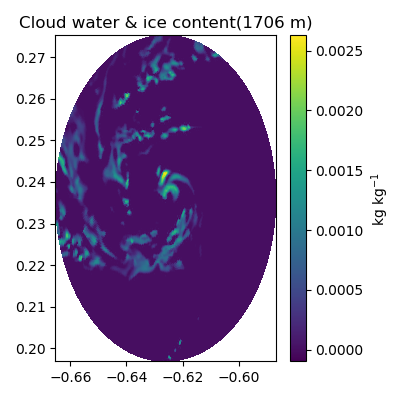

In [242]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
cs = ax.pcolor(fvar_i.x, fvar_i.y, xr.ufuncs.real(fvar_i))
ax.title.set_text('Cloud water & ice content(%s m)' %  np.int(lev_height))
cbar = plt.colorbar(cs, ax=ax)
cbar.ax.set_ylabel(r'kg kg$^{-1}$ ')

plt.tight_layout()

Plot selected fourier modes next to each other.

<IPython.core.display.Javascript object>


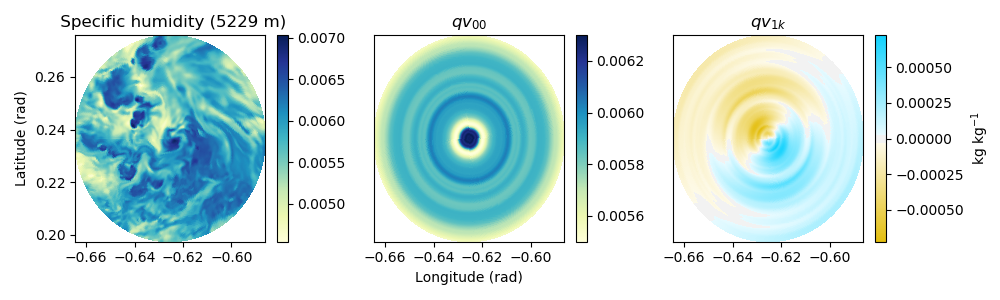

In [281]:
int_height= np.int(lev_height)

cp_map = 'YlGnBu'   # 'cividis_r' #
cp_map_div = sns.diverging_palette(68, 222, l = 78, s = 99, as_cmap=True)

fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(131)
cs = ax.pcolor(fvar0_i.x, fvar0_i.y, xr.ufuncs.real(fvar_i), cmap= cp_map) # vmin=-0.005
#ax.title.set_text(r' Cloud water & ice content (%s m)' % int_height)
ax.title.set_text(r' Specific humidity (%s m)' % int_height)
#cbar = plt.colorbar(cs, ax=ax, ticks = [0.0025, 0.002, 0.0015, 0.0010, 0.0005, 0])
cbar = plt.colorbar(cs, ax=ax)
plt.ylabel('Latitude (rad)')
plt.xlabel('')

ax = fig.add_subplot(132)
ax.axes.get_yaxis().set_visible(False)
cs = ax.pcolor(fvar1_i.x, fvar1_i.y, xr.ufuncs.real(fvar0_i), cmap= cp_map)
ax.title.set_text(r'$qv_{00}$')
cbar = plt.colorbar(cs, ax=ax)
plt.xlabel('Longitude (rad)')

ax = fig.add_subplot(133)
ax.axes.get_yaxis().set_visible(False)
cs = ax.pcolor(fvar2_i.x, fvar2_i.y, 2*xr.ufuncs.real(fvar1_i), cmap= cp_map_div)
ax.title.set_text(r'$qv_{1k}$')
cbar = plt.colorbar(cs, ax=ax)
cbar.ax.set_ylabel('kg kg$^{-1}$')
plt.xlabel('')

plt.tight_layout()

In [221]:
var_da.max()

<xarray.DataArray ()>
array(0.00300639)
Coordinates:
    time     datetime64[ns] 2016-08-17T12:00:00

#### Background

<IPython.core.display.Javascript object>


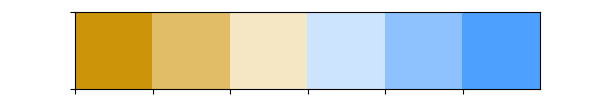

In [141]:
sns.palplot(sns.diverging_palette( 55, 250, l=65, s=99)) #, l = 40, s = 100))

<IPython.core.display.Javascript object>


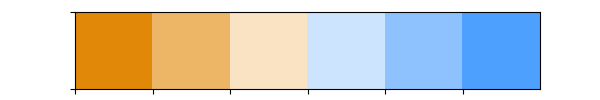

In [140]:
sns.palplot(sns.diverging_palette( 40, 250, l=65, s=99)) #, l = 40, s = 100))

<IPython.core.display.Javascript object>


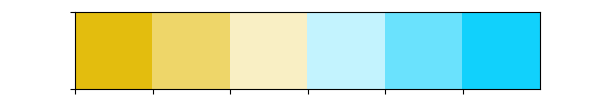

In [150]:
sns.palplot(sns.diverging_palette( 68, 222, l=78, s=99)) #, l = 40, s = 100))

In [147]:
sns.choose_diverging_palette()

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

[array([0.25199714, 0.49873371, 0.57516028, 1.        ]),
 array([0.43026136, 0.62000665, 0.67878019, 1.        ]),
 array([0.60852558, 0.74127959, 0.7824001 , 1.        ]),
 array([0.7867898 , 0.86255253, 0.88602001, 1.        ]),
 array([0.95, 0.95, 0.95, 1.  ]),
 array([0.95457726, 0.76653099, 0.78032569, 1.        ]),
 array([0.91971827, 0.58735877, 0.61174   , 1.        ]),
 array([0.88485928, 0.40818655, 0.44315432, 1.        ]),
 array([0.85104086, 0.23436275, 0.27960104, 1.        ])]

37030.0

<xarray.DataArray ()>
array(132.11516627)


<xarray.DataArray ()>
array(6.77894328e-16)